In [34]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine

from ase import Atoms, geometry, neighborlist
from ase.io import read, write
from ase.neighborlist import NeighborList
from ase.visualize import view

from scipy import sparse
from scipy.spatial.transform import Rotation

import networkx as nx

import metatensor
from rascaline import SoapPowerSpectrum
from anisoap.representations import EllipsoidalDensityProjection
from anisoap.utils import ClebschGordanReal, cg_combine, standardize_keys

In [2]:
mols = read("planar_mols.xyz", ":")

In [3]:
NLIST_KWARGS = {
    "skin": 0.3,   # doesn't matter for this application.
    "sorted": False,
    "self_interaction": False,
    "bothways": True
}

In [4]:
f1 = mols[0]
nl = neighborlist.build_neighbor_list(f1, **NLIST_KWARGS)

In [5]:
view(f1, viewer="ngl")

In [6]:
def build_graph(mol: Atoms, nl=None):
    if nl == None:
        nl = mol.build_neighbor_list(mol)
    G = nx.Graph()
    for i in range(len(mol)):
        atom = mol[i]
        nb_indices, offsets = nl.get_neighbors(i)
        nb_atoms = [mol[a] for a in nb_indices]
        el = [(i, nb) for nb in nb_indices]
        G.add_edges_from(el)
        G.nodes[i]["atom"] = mol[i]
    return G

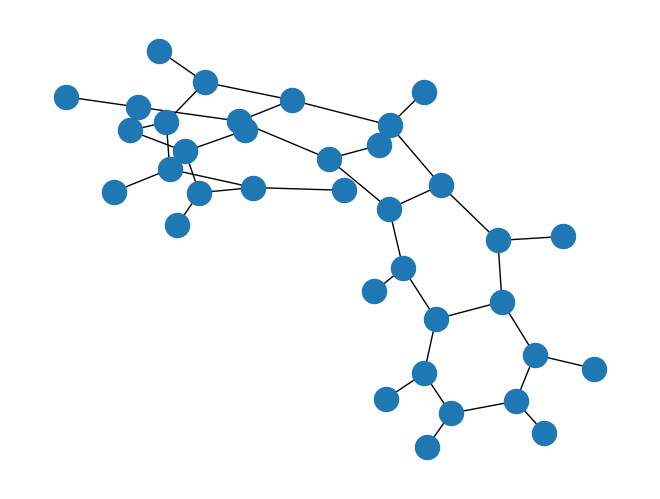

In [7]:
G = build_graph(f1, nl)
nx.draw(G)

In [8]:
rings = nx.cycle_basis(G)
rings

[[7, 3, 2, 6, 9, 11],
 [12, 8, 7, 11, 15, 17],
 [18, 14, 12, 17, 21, 23],
 [24, 20, 18, 23, 27, 28],
 [29, 26, 24, 28, 32, 33]]

In [9]:
ring_atoms = Atoms([G.nodes[i]["atom"] for i in rings[0]])
view(ring_atoms, viewer="ngl")

In [10]:
dist_vecs, _ = geometry.get_distances(ring_atoms.positions)
pos_vecs = ring_atoms.positions[0] + dist_vecs[0]
pos_vecs

array([[22.16435097, 23.06374446, 27.12292023],
       [21.36496788, 22.39716756, 28.1086141 ],
       [21.24210692, 22.90385249, 29.3774692 ],
       [21.91302342, 24.11562743, 29.74586128],
       [22.68207126, 24.79204221, 28.83292597],
       [22.83729103, 24.30340632, 27.49444151]])

In [11]:
com = pos_vecs.mean(axis=0)
com

array([22.03396858, 23.59597341, 28.44703872])

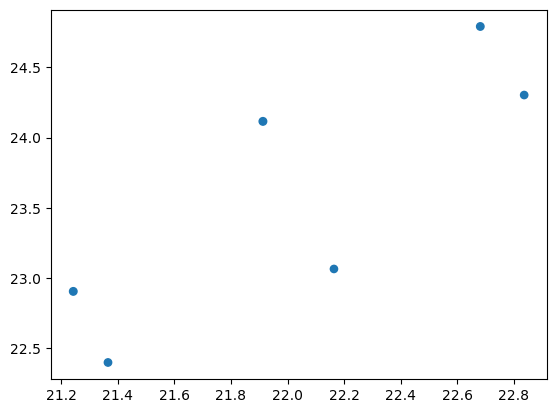

In [12]:
plt.scatter(pos_vecs[:, 0], pos_vecs[:, 1], pos_vecs[:, 2])

In [13]:
def plot_pos_vecs(pos_vecs):  
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(pos_vecs[:, 0], pos_vecs[:, 1], pos_vecs[:, 2])
    com = pos_vecs.mean(axis=0)
    ax.scatter(*com)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    return fig, ax

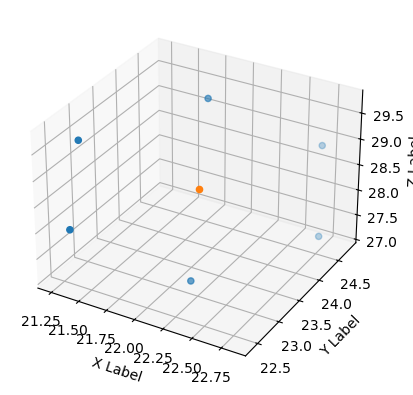

In [14]:
fig, ax = plot_pos_vecs(pos_vecs)
plt.show()

[2.25246286] [2.22871019] [0.00588264]


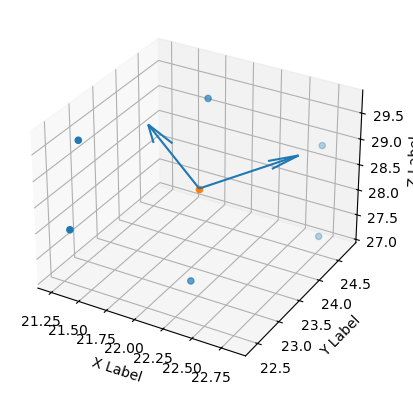

In [15]:
def plot_points_and_moments(atoms):
    dist_vecs, _ = geometry.get_distances(atoms.positions)
    pos_vecs = atoms.positions[0] + dist_vecs[0]
    com = pos_vecs.mean(axis=0)
    moments, axes = atoms.get_moments_of_inertia(vectors=True)
    mass = np.sum([atom.mass for atom in ring_atoms])
    E = np.reshape(moments, (3,1))
    coefs = np.array([[0, 1, 1],
                      [1, 0, 1],
                      [1, 1, 0]]) * mass / 5
    a, b, c = np.sqrt(np.linalg.solve(coefs, E))
    print(a, b, c)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(pos_vecs[:, 0], pos_vecs[:, 1], pos_vecs[:, 2])
    ax.scatter(*com)
    ax.quiver(*com, *axes[0], length=a[0]/2)
    ax.quiver(*com, *axes[1], length=b[0]/2)
    ax.quiver(*com, *axes[2], length=c[0]/2)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    return fig, ax

fig, ax = plot_points_and_moments(ring_atoms)
plt.show()

In [16]:
# I = XDX^-1
# X = [v_1, v_2, v_3], where v_i is ith eigenvalue
moments, axes = ring_atoms.get_moments_of_inertia(vectors=True)
print(f"moments:\n{moments}\n\naxes:\n{axes}")

moments:
[ 71.59301227  73.12715094 144.71916567]

axes:
[[ 0.46608076  0.84736254  0.25445129]
 [-0.37740693 -0.06970268  0.92342057]
 [-0.80020793  0.52642024 -0.28731341]]


In [17]:
mass = np.sum([atom.mass for atom in ring_atoms])
E = np.reshape(moments, (3,1))
coefs = np.array([[0, 1, 1],
                  [1, 0, 1],
                  [1, 1, 0]]) * mass / 5
a, b, c = np.sqrt(np.linalg.solve(coefs, E))
print(a, b, c)
print(a**2, b**2, c**2)

[2.25246286] [2.22871019] [0.00588264]
[5.07358894] [4.96714911] [3.46054491e-05]


In [24]:
rot = np.asarray(axes)
quat = Rotation.from_matrix(rot).as_quat()
quat = np.roll(quat, 1)
quat

array([-0.19850017,  0.91154843,  0.2349778 , -0.27287832])

In [36]:
ell_frame = Atoms(positions = [tuple(com)], cell = f1.cell, pbc = f1.pbc)
ell_frame.arrays["quaternions"] = [quat]
ell_frame.arrays["c_diameter[1]"] = a
ell_frame.arrays["c_diameter[2]"] = b
ell_frame.arrays["c_diameter[3]"] = c

In [31]:
ell_frame

Atoms(symbols='X', pbc=False, cell=[47.86952688, 47.86952688, 47.86952688], c_diameter[1]=..., c_diameter[2]=..., c_diameter[3]=..., quaternions=...)

In [32]:
com

array([22.03396858, 23.59597341, 28.44703872])

In [35]:
lmax, nmax, gaussian, cutoff_radius = 9, 6, 1.5, 7.0
mycg = ClebschGordanReal(lmax)

ANISOAP_HYPERS = {
    "max_angular": lmax,
    "max_radial": nmax,
    "radial_basis_name": "gto",
    "rotation_type": "quaternion",
    "rotation_key": "quaternions",
    "radial_gaussian_width": gaussian,
    "cutoff_radius": cutoff_radius,
    "basis_rcond": 1e-8,
    "basis_tol": 1e-4,
}
calculator = EllipsoidalDensityProjection(**ANISOAP_HYPERS)
rep_raw = calculator.transform(ell_frame, show_progress=True)

aniso_nu1 = standardize_keys(rep_raw)
aniso_nu2 = cg_combine(
    aniso_nu1,
    aniso_nu1,
    clebsch_gordan=mycg,
    lcut=0,
    other_keys_match=["types_center"],
)

/home/lucas/mambaforge/envs/cersonsky/lib/python3.12/site-packages/anisoap/representations/ellipsoidal_density_projection.py:540: UserWarning: In quaternion mode, quaternions are assumed to be in (w,x,y,z) format.
  warnings.warn(


TypeError: object of type 'Atom' has no len()